In [136]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import scipy.io as sio

In [137]:
example_subject_folder = "../data/MR-NIRP_Indoor/Subject1_motion_940"

example_nir_folder = os.path.join(example_subject_folder, "NIR")
example_raw_folder = os.path.join(example_subject_folder, "RGB")
example_ppg_folder = os.path.join(example_subject_folder, "PulseOX")

example_nir_img_path = os.path.join(example_nir_folder, "Frame00000.pgm")
example_raw_img_path = os.path.join(example_raw_folder, "Frame00000.pgm")
example_ppg_mat_path = os.path.join(example_ppg_folder, "pulseOx.mat")


class:  ndarray
shape:  (640, 640)
strides:  (1280, 2)
itemsize:  2
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x55dc07a539b0
byteorder:  little
byteswap:  False
type: uint16
None
max pixel value: 62624, min pixel value: 0


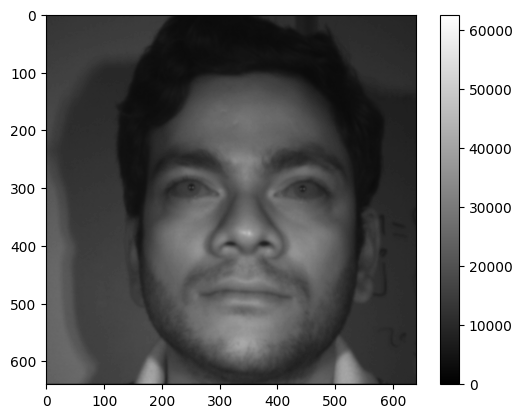

In [138]:
nir_img = cv2.imread(example_nir_img_path, cv2.IMREAD_UNCHANGED)
print(np.info(nir_img))
print(f"max pixel value: {nir_img.max()}, min pixel value: {nir_img.min()}")
plt.imshow(nir_img, cmap='gray')
plt.colorbar()


class:  ndarray
shape:  (640, 640)
strides:  (1280, 2)
itemsize:  2
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x55dc02c52930
byteorder:  little
byteswap:  False
type: uint16
None
max pixel value: 65520, min pixel value: 0


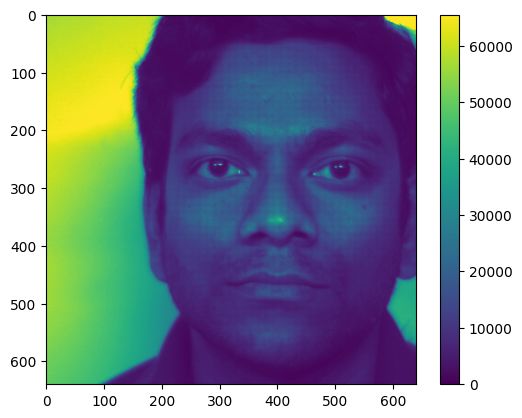

In [139]:
raw_img = cv2.imread(example_raw_img_path, cv2.IMREAD_UNCHANGED)  # Sensor format: RGGB
print(np.info(raw_img))
print(f"max pixel value: {raw_img.max()}, min pixel value: {raw_img.min()}")
plt.imshow(raw_img)
plt.colorbar()

class:  ndarray
shape:  (640, 640, 3)
strides:  (1920, 3, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x55dc02defaa0
byteorder:  little
byteswap:  False
type: uint8
None
max pixel value: 255, min pixel value: 3


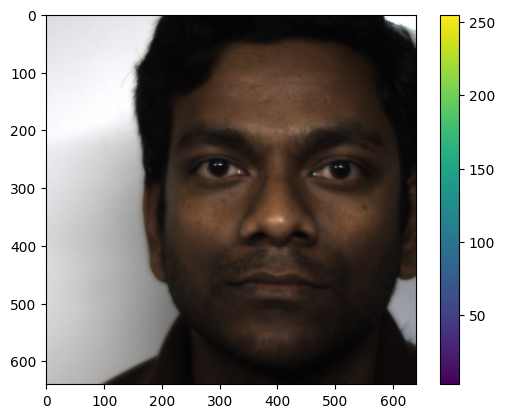

In [140]:
bayer_rg_img = cv2.normalize(raw_img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)  # Normalize raw image to 0-255
rgb_img = cv2.cvtColor(bayer_rg_img, cv2.COLOR_BAYER_RGGB2RGB)  # Demosaic RGGB raw image to RGB image
print(np.info(rgb_img))
print(f"max pixel value: {rgb_img.max()}, min pixel value: {rgb_img.min()}")
plt.imshow(rgb_img)
plt.colorbar()

In [141]:
nir_img_list = sorted(glob.glob(os.path.join(example_nir_folder, "*.pgm")))
raw_img_list = sorted(glob.glob(os.path.join(example_raw_folder, "*.pgm")))
nir_img_name_list = [os.path.basename(img_path) for img_path in nir_img_list]
raw_img_name_list = [os.path.basename(img_path) for img_path in raw_img_list]
unmatched_frame_list = list(set(nir_img_name_list) ^ set(raw_img_name_list))
print(f"Number of NIR frame: {len(nir_img_list)}")
print(f"Number of RGB frame: {len(raw_img_list)}")
print(f"Unmatched frame: {unmatched_frame_list}")

Number of NIR frame: 1967
Number of RGB frame: 1966
Unmatched frame: ['Frame01966.pgm']


In [142]:
ppg_mat = sio.loadmat(example_ppg_mat_path)
for key in ppg_mat.keys():
    if key.startswith("__"):
        continue
    print(f"Key: {key}, type: {type(ppg_mat[key])}, shape: {ppg_mat[key].shape}, dtype: {ppg_mat[key].dtype}")
    print(f"Value: {ppg_mat[key]}\n")

Key: pulseOxRecord, type: <class 'numpy.ndarray'>, shape: (1, 3910), dtype: object
Value: [[array([[43]]) array([[43]]) array([[44]]) ... array([[25]])
  array([[30]]) array([[37]])]]

Key: pulseOxTime, type: <class 'numpy.ndarray'>, shape: (1, 3910), dtype: float64
Value: [[1.51907692e+09 1.51907692e+09 1.51907692e+09 ... 1.51907698e+09
  1.51907698e+09 1.51907698e+09]]

Key: numPulseSample, type: <class 'numpy.ndarray'>, shape: (1, 1), dtype: int64
Value: [[3910]]



Text(0.5, 1.0, 'PPG Signal vs. Time')

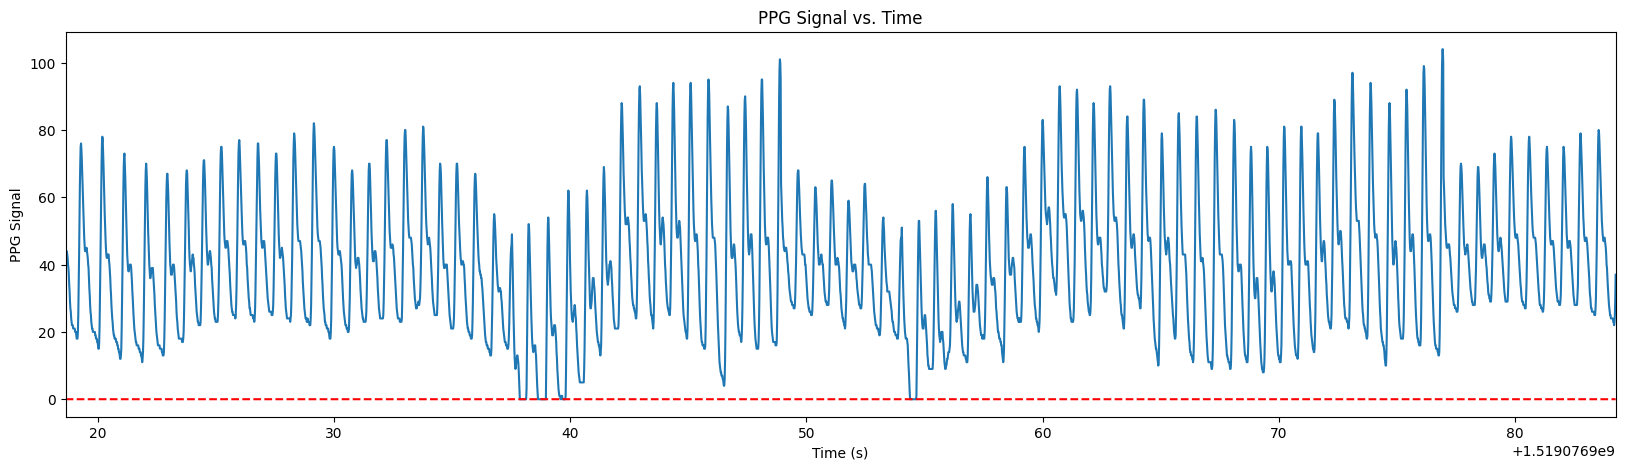

In [143]:
ppg_signal_corrupted = ppg_mat["pulseOxRecord"].squeeze()
ppg_time_corrupted = ppg_mat["pulseOxTime"][0]
ppg_signal, ppg_time = [], []
for idx, (value, time) in enumerate(zip(ppg_signal_corrupted, ppg_time_corrupted)):
    num_values = len(value[0])
    if num_values > 1:  # Multiple values at a time step due to queued delayed ppg signal
        for sub_idx, sub_value in enumerate(value[0]):
            ppg_time.append(ppg_time_corrupted[idx-1] + (sub_idx / num_values) * (time - ppg_time_corrupted[idx-1]))
            ppg_signal.append(sub_value)
    else:
        ppg_time.append(time)
        ppg_signal.append(value.item())

ppg_signal = np.array(ppg_signal)
ppg_time = np.array(ppg_time)

plt.figure(figsize=(20, 5))
plt.plot(ppg_time, ppg_signal)
plt.plot(ppg_time, np.zeros_like(ppg_time), 'r--')  # Zero means missing data, should not be used for training and evaluation
plt.xlim(ppg_time[0], ppg_time[-1])
plt.xlabel("Time (s)")
plt.ylabel("PPG Signal")
plt.title("PPG Signal vs. Time")